In [1]:
import geopandas as gpd
print(gpd.__version__)

0.11.1


In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['figure.dpi'] = 300
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # 显示所有列
from tqdm.notebook import tqdm
import geopandas as gpd
import transbigdata as tbd
import geoplot as gplt

In [2]:
trip = pd.read_csv('../location_to_trip_data_new_gcj2wgs/loc2trip_3.csv')
# 将gcj02坐标转换为WGS84坐标系，已经转换过
# 转为GeoDataFrame
trip = gpd.GeoDataFrame(trip, geometry=gpd.points_from_xy(trip.start_lng, trip.start_lat))
# 设置为WGS84坐标系
trip = trip.set_crs(epsg=4326)

# 读取网格数据
grid = pd.read_csv('E:/Data/成都数据/四环hexa/四环区域_500米hexa.csv')
# 转为GeoDataFrame
from shapely import wkt
grid['geometry'] = grid['geometry'].apply(wkt.loads)
grid = gpd.GeoDataFrame(grid, geometry='geometry')
grid = grid.set_crs(epsg=4326)
grid_proj = grid.to_crs(epsg=32648)

In [3]:
sihuan = gpd.read_file('E:/Data/成都数据/成都道路_好用/成都四环/四环.shp')
# sihuan = sihuan.to_crs(epsg=4326)
sihuan_proj = sihuan.to_crs(epsg=32648)

### 计算路网密度 
+ 进行矢量数据的面积和长度计算时，先转化为投影坐标系，32648

In [4]:
# 读取路网数据
yao_road = gpd.read_file('E:/Data/成都数据/成都道路_好用/成都道路/成都转换投影缓冲15轮廓线.shp', encoding='utf-8')
yao_road = yao_road.to_crs(epsg=4326)
yao_road.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# 设置为utm-48n坐标系
yao_road_proj = yao_road.to_crs(epsg=32648)
yao_road_proj.crs
print((yao_road_proj.clip(mask=grid_proj.unary_union) .length /
      2/1000) / (grid_proj.unary_union.area / 1000 / 1000))


0    6.152179
dtype: float64


### 汇总所有poi数据

In [60]:
# 合并所有poi数据
poi_path = 'E:/Data/成都数据/成都POI/'
if not os.path.exists(poi_path+'poi_all.csv'): # 如果文件不存在
    print('poi_all.csv不存在，开始合并')
    import os
    poi_files = os.listdir(poi_path) # 获取文件夹下所有文件
    poi_all = pd.DataFrame() # 创建一个空的DataFrame，用于存储所有的poi数据

    for file in tqdm(poi_files):
        print('正在处理文件：', file,end=' ')
        df_poi = pd.read_excel(poi_path + file)
        print('文件大小：', df_poi.shape, end=' ')
        print('文件列名：', df_poi.columns)
        poi_all = pd.concat([poi_all, df_poi], axis=0)
    # 重置索引
    poi_all = poi_all.reset_index(drop=True)
    # 保存数据
    poi_all.to_csv(poi_path+'poi_all.csv', index=False)
else:
    print('poi_all.csv存在，直接读取')
    poi_all = pd.read_csv(poi_path+'poi_all.csv',encoding='utf-8-sig')
poi_all = gpd.GeoDataFrame(poi_all, geometry=gpd.points_from_xy(poi_all.WGS84_经度, poi_all.WGS84_纬度))
poi_all = poi_all.set_crs(epsg=4326)
print('poi_all数据大小：', poi_all.shape)
print('poi_all数据列名：', poi_all.columns)


poi_all.csv存在，直接读取
poi_all数据大小： (418854, 11)
poi_all数据列名： Index(['名称', '大类', '中类', '小类', '地址', '省', '市', '区', 'WGS84_经度', 'WGS84_纬度',
       'geometry'],
      dtype='object')


In [58]:
poi_all.crs

In [106]:
for i in tqdm(range(100, 999, 100)):
    # 创建网格数据
    grid,_ = tbd.area_to_grid(location=sihuan,accuracy=i,method='rect')
    print('网格大小：', i, '米', end=' ')
    print('网格数量：', grid.shape[0], end=' ')
    grid.drop(columns=['LONCOL','LATCOL'], inplace=True)
    grid['poly_id'] = range(grid.shape[0])
    grid = grid[['poly_id','geometry']].reset_index(drop=True)
    
    grid = grid.set_crs(epsg=4326)
    print('网格裁切前面积：', grid.to_crs(epsg=32648).unary_union.area / 1000 / 1000, '平方千米', end=' ')
    grid = grid.clip(mask=sihuan)
    grid_proj = grid.to_crs(epsg=32648)
    print('网格裁切后面积：', grid_proj.unary_union.area / 1000 / 1000, '平方千米')

    # 计算网格内的路网密度 km/km2
    # overlay用法：https://geopandas.org/set_operations.html
    grid_road_overlay = yao_road.overlay(
        grid, how='intersection', keep_geom_type=False) # 交集，保留网格的几何类型 
    grid_road_overlay.set_index('poly_id', inplace=True) # 设置poly_id为索引，方便后续合并
    grid_road_overlay_proj = grid_road_overlay.to_crs(epsg=32648) # 转为utm-48n坐标系
    grid_proj['road_length'] = grid_road_overlay_proj.length / 1000 # 路网长度
    grid_proj['road_density'] = grid_proj['road_length'] / \
        grid_proj.area * 1000000 / 2 # 路网密度
    grid_proj = grid_proj.fillna(0)
    # 设置为WGS84坐标系
    grid_road = grid_proj.to_crs(epsg=4326)
    grid_road.rename(columns={'index': 'poly_id'}, inplace=True)


    # 计算网格内的POI密度
    dfsjoin = gpd.sjoin(grid_road, poi_all)  # Spatial join Points to polygons
    # 根据poly_id分组，计算每个网格内的POI数量
    dfpivot = pd.pivot_table(dfsjoin, index='poly_id',
                             columns='大类', aggfunc={'大类': len})
    dfpivot.columns = dfpivot.columns.droplevel()
    dfpivot = dfpivot.fillna(0)
    # 将POI数量合并到网格路网密度数据中
    grid_road_poi = grid_road.merge(dfpivot, how='left', on='poly_id') 
    grid_road_poi = grid_road_poi.fillna(0)
    grid_road_poi = grid_road_poi.sort_values(by='poly_id')
    
    grid_road_poi.to_csv('E:/Data/成都数据/rect_road_poi/rect%d.csv'%i, index=False, encoding='utf-8-sig') 


  0%|          | 0/9 [00:00<?, ?it/s]

网格大小： 100 米 网格数量： 55239 网格裁切前面积： 551.5059098923363 平方千米 网格裁切后面积： 546.407800853659 平方千米
网格大小： 200 米 网格数量： 13940 网格裁切前面积： 556.7077333085969 平方千米 网格裁切后面积： 546.407801436065 平方千米
网格大小： 300 米 网格数量： 6255 网格裁切前面积： 562.0494663001855 平方千米 网格裁切后面积： 546.4078003972784 平方千米
网格大小： 400 米 网格数量： 3552 网格裁切前面积： 567.4112233726885 平方千米 网格裁切后面积： 546.4077965187106 平方千米
网格大小： 500 米 网格数量： 2293 网格裁切前面积： 572.3329516911896 平方千米 网格裁切后面积： 546.4077979730657 平方千米
网格大小： 600 米 网格数量： 1615 网格裁切前面积： 580.4684076687146 平方千米 网格裁切后面积： 546.4078065822949 平方千米
网格大小： 700 米 网格数量： 1196 网格裁切前面积： 585.1029624639127 平方千米 网格裁切后面积： 546.4077880337564 平方千米
网格大小： 800 米 网格数量： 923 网格裁切前面积： 589.7753692100302 平方千米 网格裁切后面积： 546.4077904021692 平方千米
网格大小： 900 米 网格数量： 733 网格裁切前面积： 592.7803338519485 平方千米 网格裁切后面积： 546.4077866539025 平方千米


<AxesSubplot:>

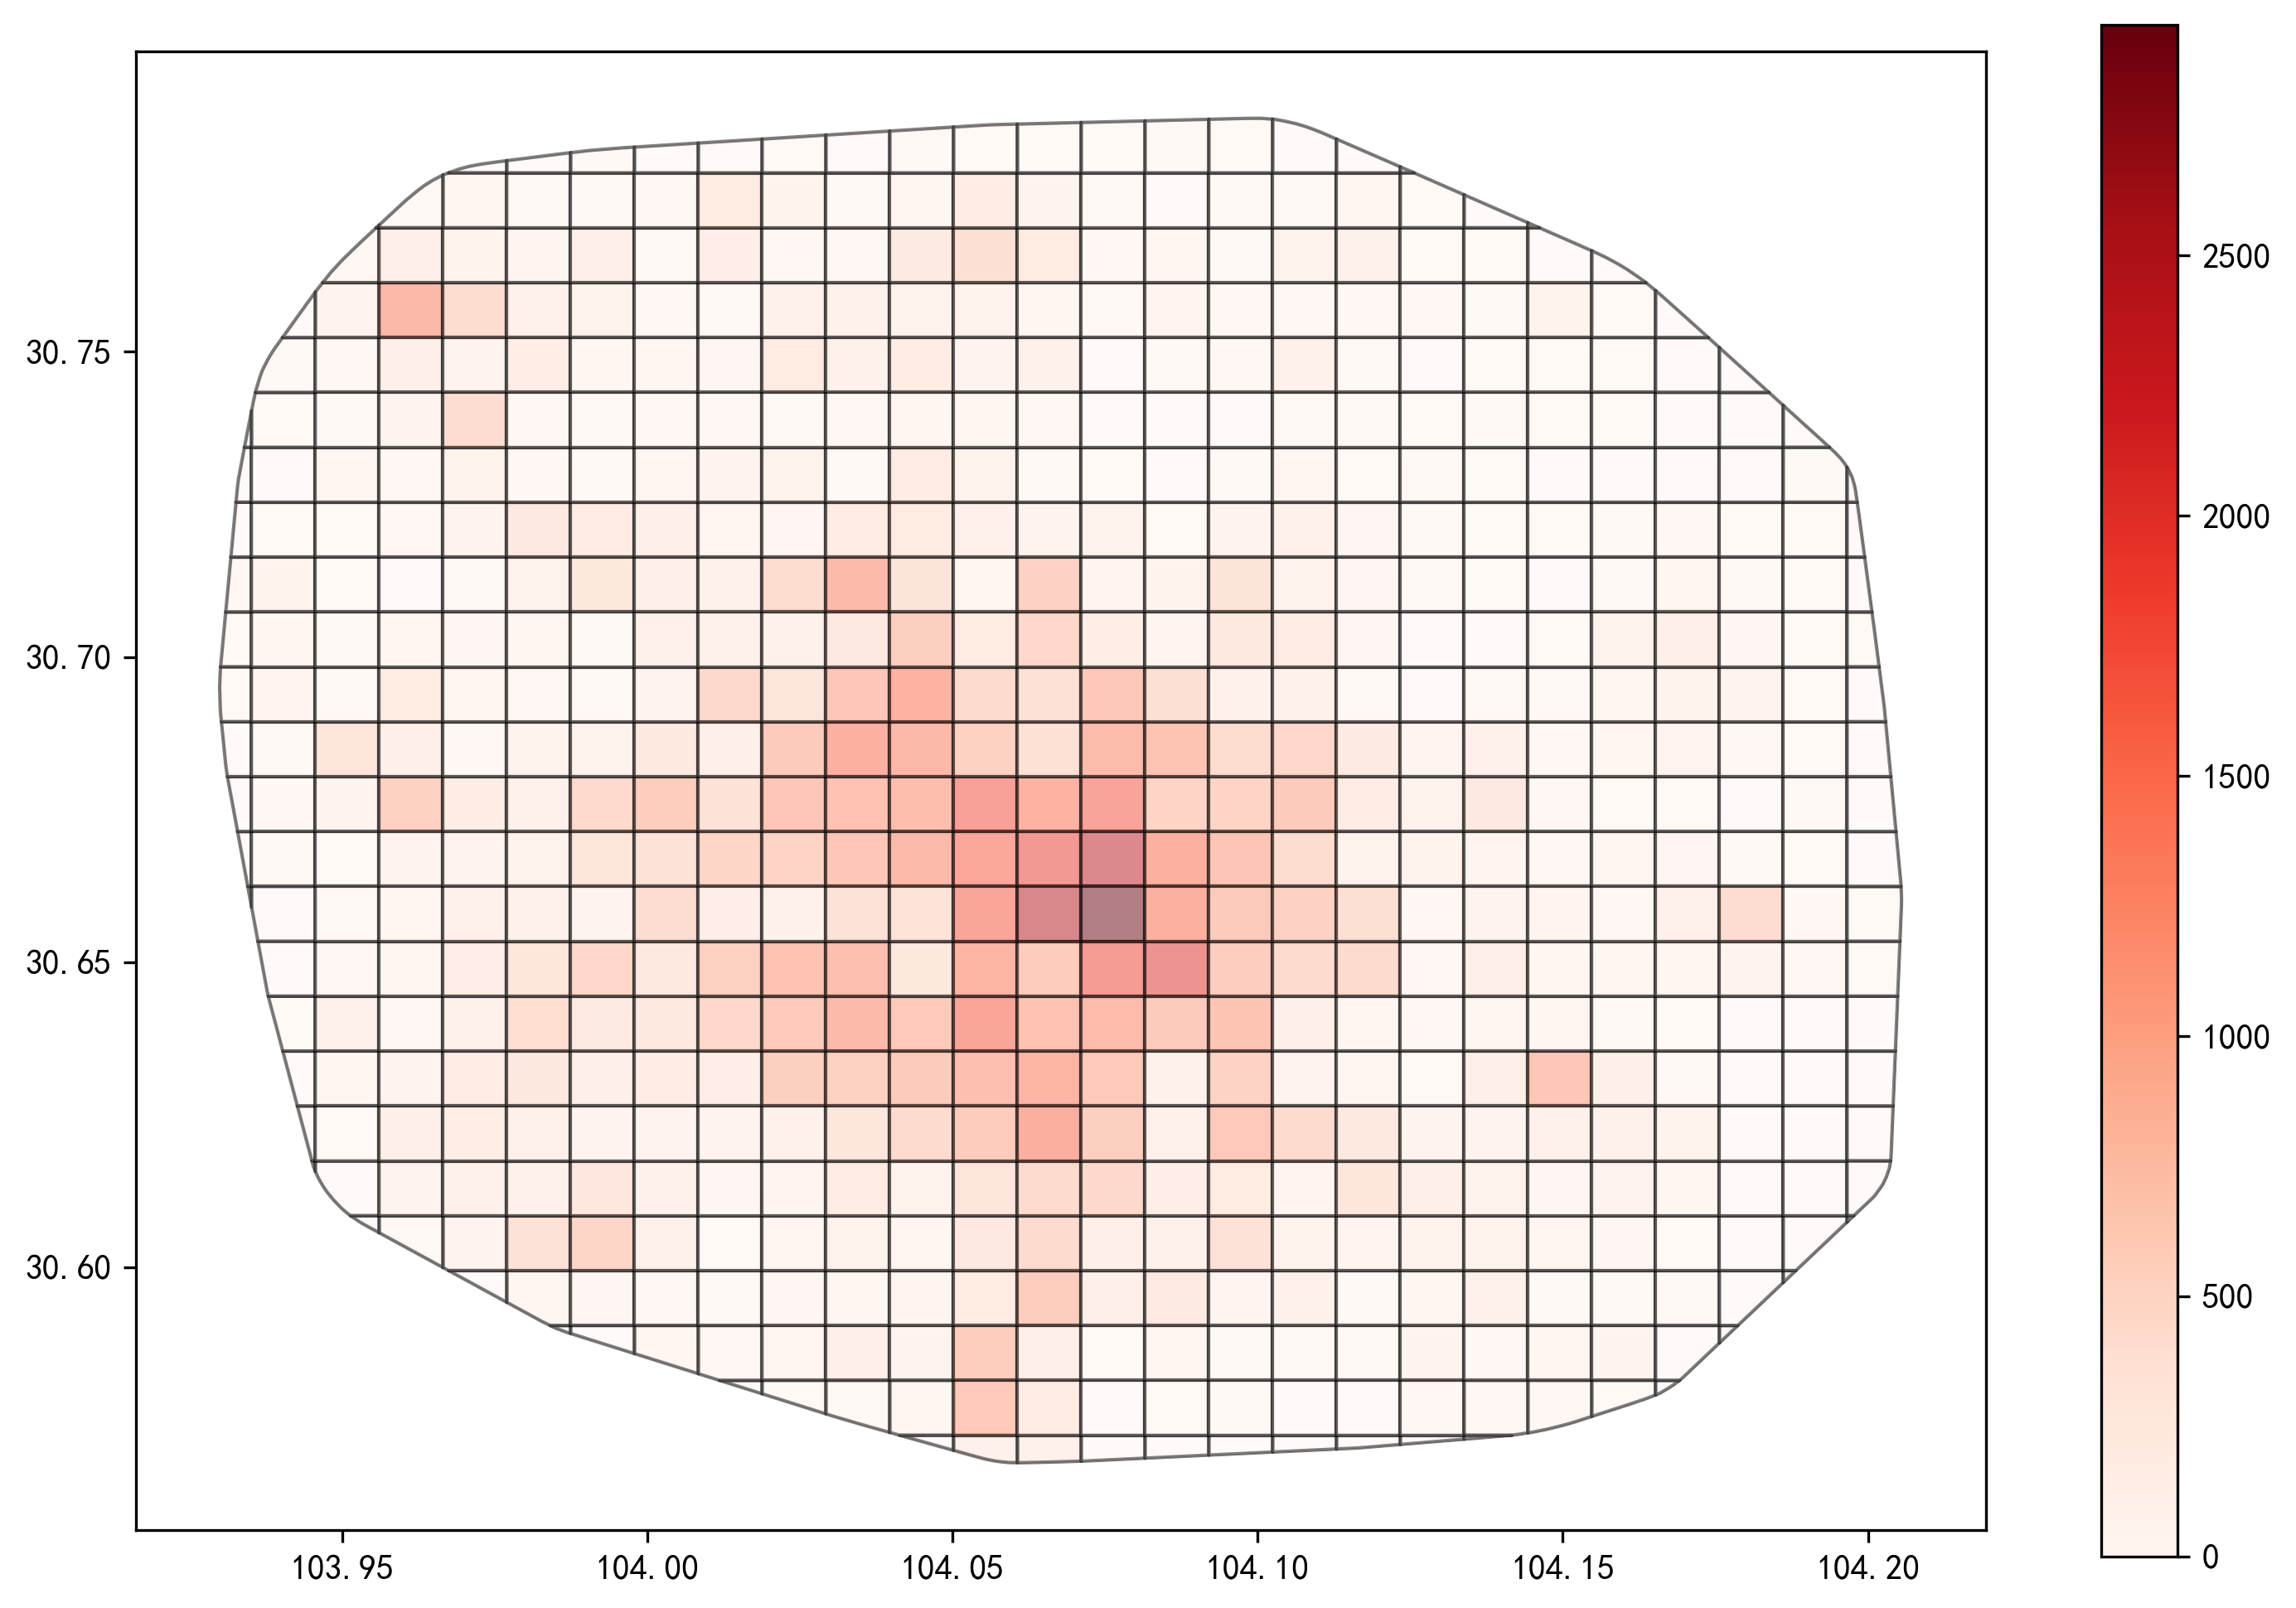

In [103]:
fig, ax = plt.subplots(1,1,figsize=(12, 8)) # 可使用GridSpec用法
sihuan.plot( ax=ax, edgecolor='black', linewidth=0.1,alpha=0.5, color='white')
grid_road_poi.plot(column='poi_num',edgecolor='black' , cmap='Reds', legend=True, ax=ax, alpha=0.5)

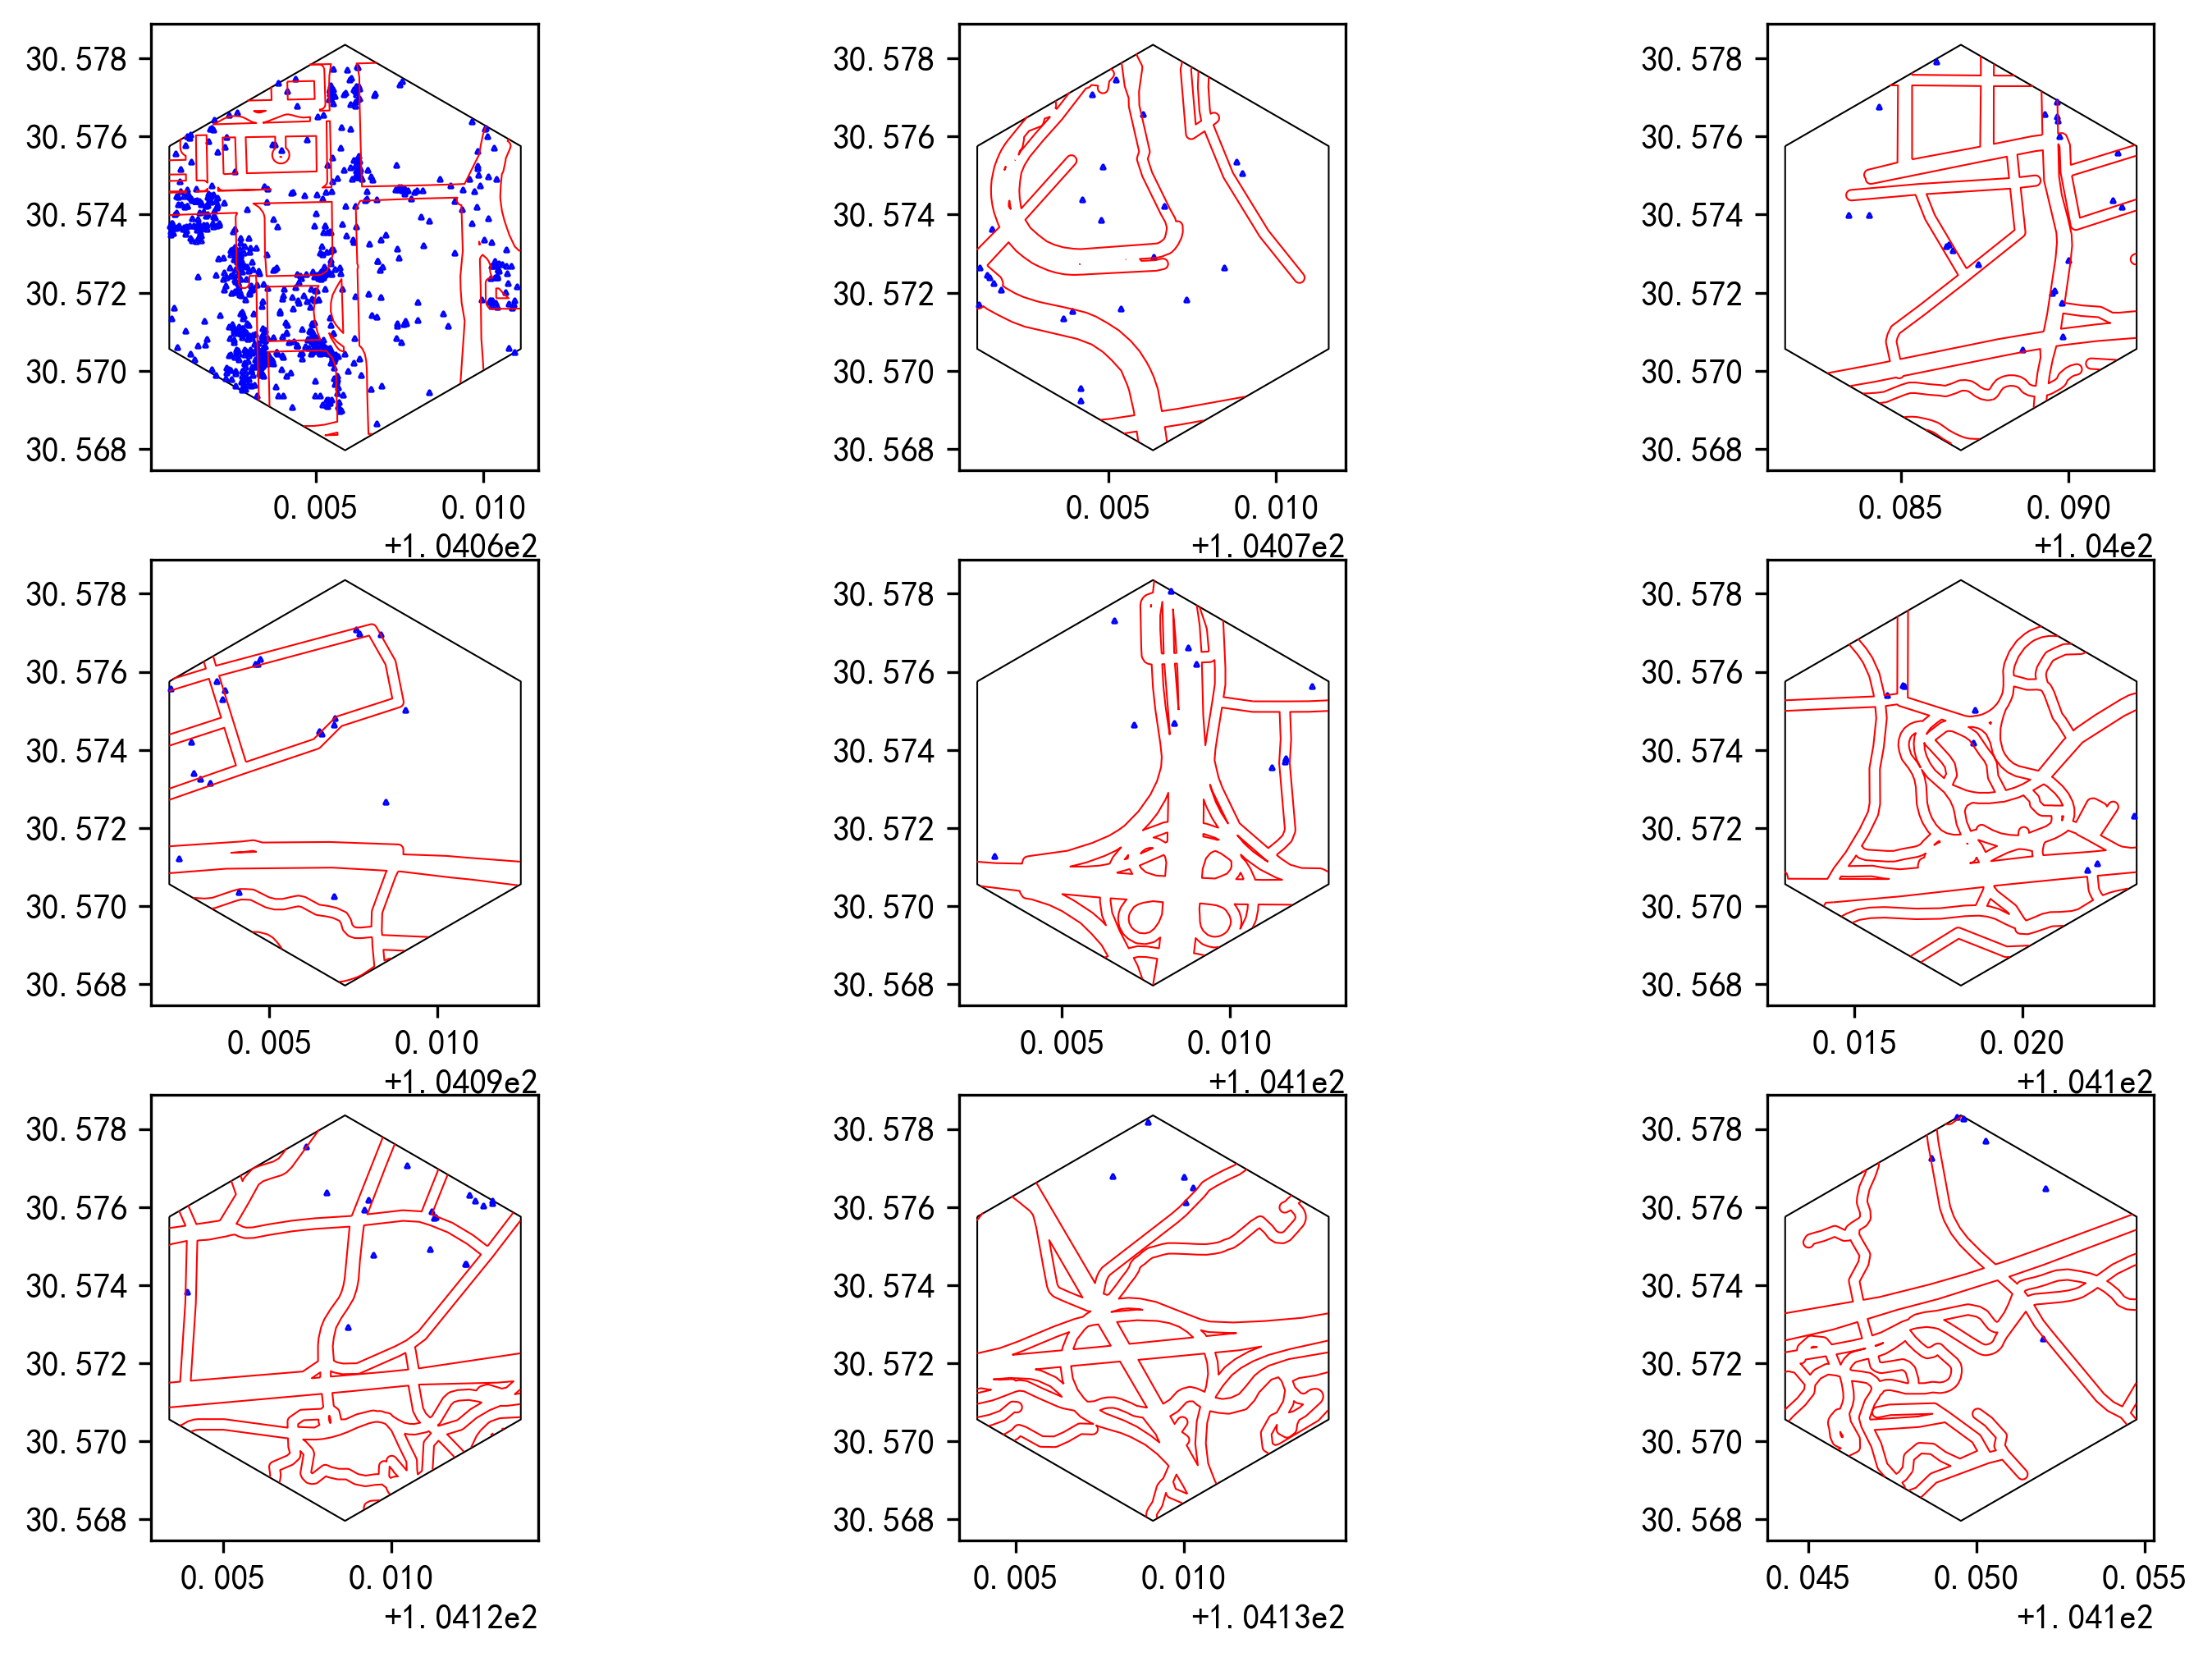

In [37]:
# 读取数据并转为地理坐标，原数据为投影坐标系EPSG:32648,utm-48n

# 读取缓冲区
# buffer = gpd.read_file('C:/Users/yongqi/Desktop/main_road/缓冲.shp')
# bb = buffer.boundary
# plt.ticklabel_format(style='plain')
fig, axes = plt.subplots(3,3,figsize=(12, 8)) # 可使用GridSpec用法
for i in range(1,4):
    for j in range(1,4):
        # ax[i,j].ticklabel_format(style='plain')       

        grid.iloc[i*3+j:i*3+j+1,0].plot(ax=axes[i-1,j-1], color='white', edgecolor='black', linewidth=0.5)

        yao_road.clip(mask=grid.iloc[i*3+j:i*3+j+1,0]).plot(ax=axes[i-1,j-1],color='red',linewidth=0.5)
        
        trip.clip(mask=grid.iloc[i*3+j:i*3+j+1,0]).plot(ax=axes[i-1,j-1],color='blue',markersize=1,marker='^', legend=True)
        # ax[i,j].set_title('第'+str(i*3+j+1)+'个网格')
        # 关闭科学计数法
        # ax[i,j].set_xlim(104.011, 104.088)
    # grid.iloc[i:i+1,:].plot(ax=ax[i], color='white', edgecolor='black', linewidth=0.5)
    # bike_road.clip(mask=grid.iloc[i:i+1,:]).plot(ax=ax[i],column='length', cmap='Reds', legend=True)
    # trip.clip(mask=grid.iloc[i:i+1,:]).plot(ax=ax[i],color='blue',markersize=1,marker='^', legend=True)

In [58]:
grid.iloc[100:105,:]

,geometry,index,num
100,"POLYGON ((103.96130 30.61471, 103.96653 30.617...",100,841
101,"POLYGON ((103.97176 30.61471, 103.97698 30.617...",101,449
102,"POLYGON ((103.98221 30.61471, 103.98744 30.617...",102,1894
103,"POLYGON ((103.99267 30.61471, 103.99790 30.617...",103,1316
104,"POLYGON ((104.00313 30.61471, 104.00835 30.617...",104,1224


## 绘制道路及起点示意图

In [62]:
import folium
need_mask = grid.iloc[4:5,:]
m = folium.Map([(need_mask.centroid).y.values,(need_mask.centroid).x.values],
               tiles='OpenStreetMap',
               zoom_start=15,
               control_scale=True
              )
# folium添加shp文件
# 添加网格
folium.GeoJson(need_mask).add_to(m)
# 添加道路
folium.GeoJson(yao_road.clip(mask=need_mask) ).add_to(m)
# 添加车辆点
folium.GeoJson((trip.clip(mask=need_mask)) ).add_to(m)

m
# m.save('C:/Users/yongqi/Desktop/test.html')

<AxesSubplot:>

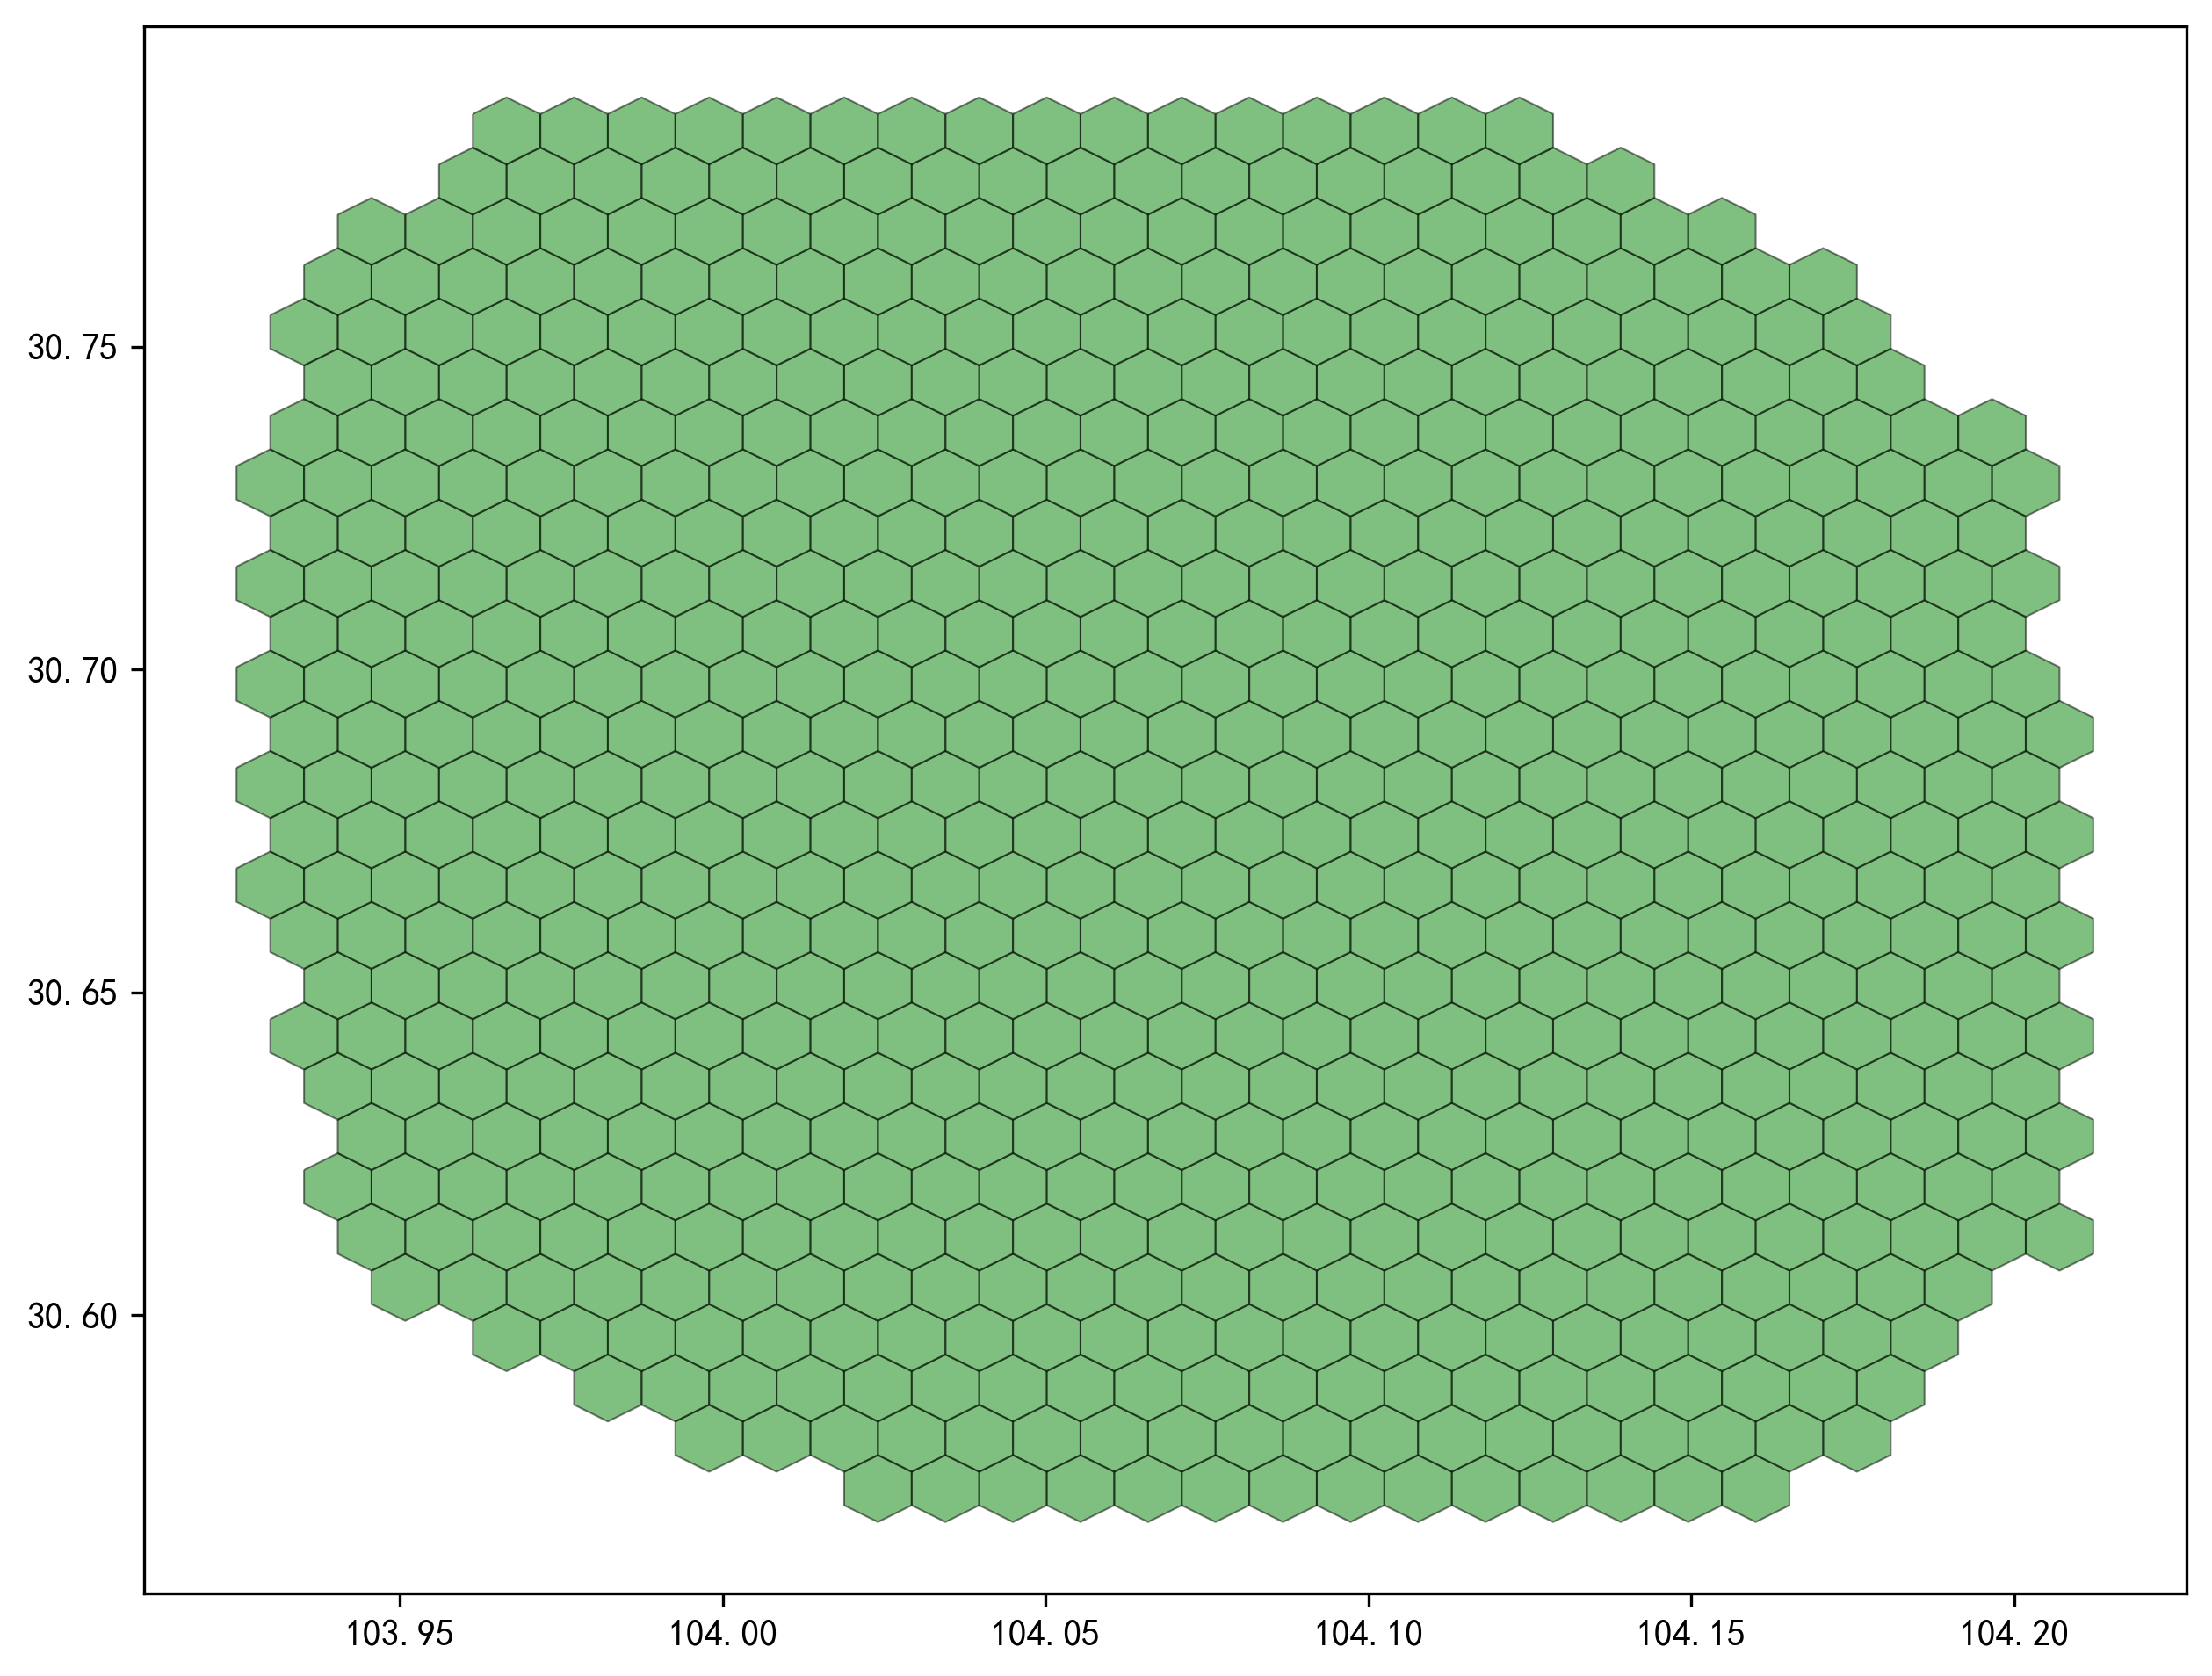

In [5]:
grid.plot(figsize=(10,10), alpha=0.5, color='green', edgecolor='k', linewidth=0.5)

In [39]:
wg = grid.copy()
# 网格中心点
wg['geometry'] = wg['geometry'].centroid
wg

,geometry,index,num
0,POINT (104.02404 30.57317),0,0
1,POINT (104.03450 30.57317),1,22
2,POINT (104.04495 30.57317),2,240
3,POINT (104.05541 30.57317),3,1990
4,POINT (104.06587 30.57317),4,1318
...,...,...,...
670,POINT (104.08155 30.78345),670,14
671,POINT (104.09201 30.78345),671,6
672,POINT (104.10246 30.78345),672,3
673,POINT (104.11292 30.78345),673,6


In [37]:
trip

,bikeid,start_time,start_lon,start_lat,end_time,end_lng,end_lat,time_difference,distance,newlon,newlat,geometry
0,206546277,2018-03-07 05:52:00,104.004300,30.744423,2018-03-07 06:54:00,104.008222,30.733850,62.0,1548.052441,104.001974,30.746954,POINT (104.00430 30.74442)
1,236500008,2018-03-07 08:38:00,104.099908,30.681653,2018-03-07 08:46:00,104.093619,30.681406,8.0,627.881233,104.097364,30.684040,POINT (104.09991 30.68165)
2,236500008,2018-03-07 09:00:00,104.093619,30.681406,2018-03-07 09:08:00,104.083923,30.688776,8.0,1743.868444,104.091078,30.683793,POINT (104.09362 30.68141)
3,236500008,2018-03-07 09:14:00,104.083923,30.688776,2018-03-07 09:18:00,104.060144,30.687888,4.0,2369.069552,104.081389,30.691164,POINT (104.08392 30.68878)
4,236500008,2018-03-07 09:20:00,104.060144,30.687888,2018-03-07 09:26:00,104.083017,30.690231,6.0,2444.030871,104.057647,30.690305,POINT (104.06014 30.68789)
...,...,...,...,...,...,...,...,...,...,...,...,...
659488,8716020377,2018-03-07 09:52:00,104.051253,30.615377,2018-03-07 10:02:00,104.039003,30.613013,10.0,1431.971964,104.048780,30.617841,POINT (104.05125 30.61538)
659489,8716020377,2018-03-07 11:56:00,104.039003,30.613013,2018-03-07 12:04:00,104.048144,30.608566,8.0,1366.422793,104.036564,30.615506,POINT (104.03900 30.61301)
659490,8716020377,2018-03-07 12:56:00,104.048144,30.608566,2018-03-07 13:06:00,104.041322,30.602478,10.0,1327.180151,104.045679,30.611040,POINT (104.04814 30.60857)
659491,8716020377,2018-03-07 13:08:00,104.041322,30.602478,2018-03-07 13:16:00,104.080997,30.631279,8.0,6985.344536,104.038877,30.604969,POINT (104.04132 30.60248)


In [41]:
from scipy.spatial import cKDTree

nB = np.array(list(wg.geometry.apply(lambda x: (x.x, x.y))))

nO = np.array(list(trip.geometry.apply((lambda x:(x.x,x.y)))))

btree = cKDTree(nB)

distO, idxO = btree.query(nO, k=1)

trip['indexO'] = idxO

wg['index'] = range(wg.shape[0])

trip_data = pd.merge(trip, wg[['index']], left_on='indexO',right_on='index')


In [42]:
trip_data

,bikeid,start_time,start_lon,start_lat,end_time,end_lng,end_lat,time_difference,distance,newlon,newlat,geometry,indexO,index
0,206546277,2018-03-07 05:52:00,104.004300,30.744423,2018-03-07 06:54:00,104.008222,30.733850,62.0,1548.052441,104.001974,30.746954,POINT (104.00430 30.74442),555,555
1,236504741,2018-03-07 18:56:00,104.002000,30.744810,2018-03-07 19:20:00,104.033485,30.734180,24.0,4186.363008,103.999682,30.747347,POINT (104.00200 30.74481),555,555
2,280065013,2018-03-07 12:12:00,104.005260,30.746805,2018-03-07 12:16:00,104.007197,30.749073,4.0,436.735143,104.002930,30.749331,POINT (104.00526 30.74680),555,555
3,280117769,2018-03-07 00:02:00,104.005325,30.747223,2018-03-07 00:48:00,104.036076,30.714352,46.0,6584.967610,104.002995,30.749749,POINT (104.00532 30.74722),555,555
4,286004873,2018-03-07 18:12:00,104.007324,30.744886,2018-03-07 18:24:00,104.002565,30.743248,12.0,636.227613,104.004987,30.747407,POINT (104.00732 30.74489),555,555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659488,8642534664,2018-03-07 18:12:00,103.939583,30.617841,2018-03-07 18:44:00,103.913947,30.599915,32.0,4437.745896,103.937467,30.620597,POINT (103.93958 30.61784),124,124
659489,8642540822,2018-03-07 14:34:00,103.931889,30.618115,2018-03-07 14:52:00,103.983345,30.644789,18.0,7874.185697,103.929788,30.620882,POINT (103.93189 30.61811),124,124
659490,8640261411,2018-03-07 16:14:00,103.936523,30.723058,2018-03-07 17:30:00,103.921785,30.739997,76.0,3287.560186,103.934409,30.725771,POINT (103.93652 30.72306),470,470
659491,8642540259,2018-03-07 17:52:00,103.934586,30.717800,2018-03-07 17:56:00,103.926806,30.713065,4.0,1268.514881,103.932476,30.720519,POINT (103.93459 30.71780),470,470
